In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_squared_error
from PIL import Image

sns.set_theme(style="whitegrid")


In [2]:
# Load the dataset
df = pd.read_csv('hospital_dataset.csv')
print("Dataset loaded. Here are first 5 rows:")
print(df.head())


Dataset loaded. Here are first 5 rows:
   patient_id   department  staff_id     staff_role  treatment_cost  \
0           1  Orthopedics        67   Junior Nurse   106070.489150   
1           2    Neurology        91   Junior Nurse   236163.390945   
2           3    Radiology        50   Junior Nurse    22897.430363   
3           4    Neurology        89   Junior Nurse    39103.471207   
4           5    Neurology        94  Senior Doctor   107291.724669   

   staff_expenses  operational_costs        date  
0           50000              18000  2025-07-04  
1           50000              25000  2025-03-03  
2           50000              15000  2025-02-21  
3           50000              25000  2025-07-08  
4          200000              25000  2025-02-09  


In [3]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# to detect outliers or anomalies
print("\nSummary statistics:")
print(df.describe())

# Check data types
print("\nData types:")
print(df.dtypes)

# Convert categorical columns if needed (e.g., department)
df['department'] = df['department'].astype('category')

# Create new feature: total_cost = staff_expenses + operational_costs
df['total_cost'] = df['staff_expenses'] + df['operational_costs']
print("\nAfter preprocessing, sample data:")
print(df.head())



Missing values per column:
patient_id           0
department           0
staff_id             0
staff_role           0
treatment_cost       0
staff_expenses       0
operational_costs    0
date                 0
dtype: int64

Summary statistics:
        patient_id    staff_id  treatment_cost  staff_expenses  \
count  2000.000000  2000.00000     2000.000000     2000.000000   
mean   1000.500000    50.27950   100945.673528   108195.000000   
std     577.494589    29.27632    73563.220668    66613.892548   
min       1.000000     1.00000     8071.186542    30000.000000   
25%     500.750000    24.00000    31091.521426    50000.000000   
50%    1000.500000    50.00000    90577.668767    80000.000000   
75%    1500.250000    76.00000   148543.820060   120000.000000   
max    2000.000000   100.00000   299039.418375   300000.000000   

       operational_costs  
count        2000.000000  
mean        25694.000000  
std         12599.592806  
min         15000.000000  
25%         18000.000000

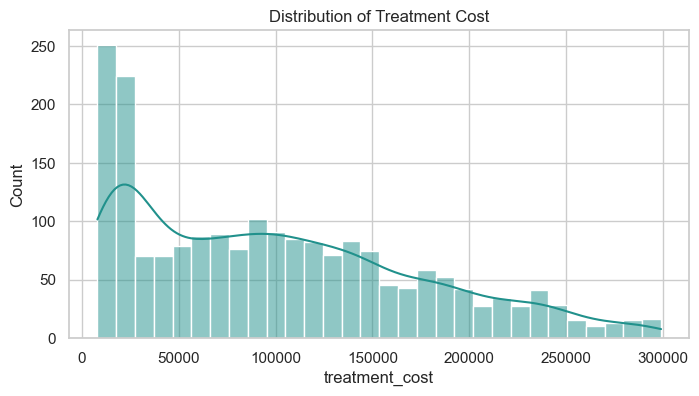

In [4]:
# Distribution of treatment_cost
plt.figure(figsize=(8,4))
sns.histplot(df['treatment_cost'], bins=30, kde=True, color=sns.color_palette("viridis", 1)[0])
plt.title('Distribution of Treatment Cost')
plt.show()

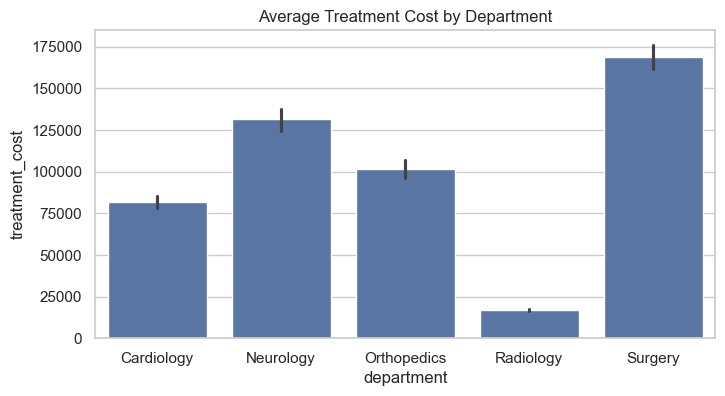

In [5]:
# Average treatment cost by department
plt.figure(figsize=(8,4))
sns.barplot(x='department', y='treatment_cost', data=df)
plt.title('Average Treatment Cost by Department')
plt.show()

In [6]:
df['date'] = pd.to_datetime(df['date'])
# General dataset info
num_patients = df['patient_id'].nunique()
num_staff = df['staff_id'].nunique()
num_departments = df['department'].nunique()
staff_id_min = df['staff_id'].min()
staff_id_max = df['staff_id'].max()
date_min = df['date'].min()
date_max = df['date'].max()
num_staff_roles = df['staff_role'].nunique()

# Print summary
print("📊 General Dataset Summary")
print(f"Total patients         : {num_patients}")
print(f"Total staff members    : {num_staff}")
print(f"Number of departments  : {num_departments}")
print(f"Number of staff roles  : {num_staff_roles}")
print(f"Staff ID range         : {staff_id_min} - {staff_id_max}")
print(f"Time period covered    : {date_min.date()} to {date_max.date()}")
print(f"Dataset total rows     : {len(df)}")

# Optional: List unique departments and roles
print("\nDepartments:", df['department'].unique())
print("Staff Roles:", df['staff_role'].unique())


📊 General Dataset Summary
Total patients         : 2000
Total staff members    : 100
Number of departments  : 5
Number of staff roles  : 6
Staff ID range         : 1 - 100
Time period covered    : 2025-01-01 to 2025-07-31
Dataset total rows     : 2000

Departments: ['Orthopedics', 'Neurology', 'Radiology', 'Surgery', 'Cardiology']
Categories (5, object): ['Cardiology', 'Neurology', 'Orthopedics', 'Radiology', 'Surgery']
Staff Roles: ['Junior Nurse' 'Senior Doctor' 'Junior Doctor' 'Chief Doctor'
 'Senior Nurse' 'Receptionist']


In [7]:
# Encode department as categorical numeric in the original DataFrame
df['department_code'] = df['department'].cat.codes
df['staff_id_code'] = df['staff_id'].astype('category').cat.codes
df['date'] = pd.to_datetime(df['date'])
df['total_cost'] = df['staff_expenses'] + df['operational_costs']
df['staff_expense_ratio'] = df['staff_expenses'] / df['treatment_cost']

# Features for modeling
features = df[['staff_expenses', 'operational_costs', 'department_code', 'staff_id_code', 'total_cost', 'staff_expense_ratio']]
target = df['treatment_cost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print(f"\nTraining samples: {len(X_train)}, Testing samples: {len(X_test)}")



Training samples: 1600, Testing samples: 400


In [8]:
#Linear Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test data
y_pred_lr = lr_model.predict(X_test)

# Evaluate
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("\nModel Performance on Test Data(LR):")
print(f"MAE: ₹{mae_lr:.2f}")
print(f"RMSE:  ₹{rmse_lr:.2f}")
print(f"R² Score: {r2_lr:.4f}")



Model Performance on Test Data(LR):
MAE: ₹42678.66
RMSE:  ₹52113.70
R² Score: 0.4818


In [9]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Calculate metrics
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("\nModel Performance on Test Data(RF):")
print(f"MAE: ₹{mae_rf:.2f}")
print(f"RMSE:  ₹{rmse_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")


Model Performance on Test Data(RF):
MAE: ₹1075.30
RMSE:  ₹2073.88
R² Score: 0.9992


In [10]:
# Linear Regression vs Random Forest
print("Model Performance Comparison on Test Data:")
if r2_rf - r2_lr > 0.05:
    print("\nRandom Forest performs significantly better. Recommend using Random Forest.")
else:
    print("\nPerformances are similar. You may choose Linear Regression for interpretability or Random Forest for slight accuracy gain.")


Model Performance Comparison on Test Data:

Random Forest performs significantly better. Recommend using Random Forest.


In [11]:
# Convert matplotlib figure to PIL Image 
def plot_to_image():
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches="tight")
    plt.close()
    buf.seek(0)
    img = Image.open(buf)
    return img

In [12]:
# Patient & Revenue 
def patient_revenue_section(start_date, end_date=""):
    start_date = pd.to_datetime(start_date)
    if end_date.strip() == "":
        end_date = start_date
    else:
        end_date = pd.to_datetime(end_date)
    df_period = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    
    num_patients = df_period['patient_id'].nunique()
    total_revenue = df_period['treatment_cost'].sum()
    avg_treatment_cost = total_revenue / num_patients if num_patients > 0 else 0

    growth_rate = 0.05
    months = np.arange(1, 13)
    monthly_revenue = total_revenue * (1 + growth_rate) ** (months - 1)
    df_revenue = pd.DataFrame({"Month": months, "Revenue": monthly_revenue})

    insights = (
        f"Period: {start_date.date()} to {end_date.date()}\n"
        f"Number of Patients: {num_patients}\n"
        f"Total Revenue: ₹{total_revenue:,.2f}\n"
        f"Average Treatment Cost: ₹{avg_treatment_cost:,.2f}\n"
        f"Projected Revenue After 12 Months: ₹{monthly_revenue[-1]:,.2f}"
    )

    # Line chart for projected revenue
    plt.figure(figsize=(7,3.5))
    sns.barplot(x="Month", y="Revenue", data=df_revenue, hue="Month", palette="Blues_d", dodge=False)
    plt.title("Projected Revenue Growth Over 12 Months")
    plt.xlabel("Month")
    plt.ylabel("Revenue (₹)")
    plt.tight_layout()
    img = plot_to_image()

    return insights, img, total_revenue

In [13]:
# Staff & Salary 
def staff_salary_section(start_date, end_date=""):
    start_date = pd.to_datetime(start_date)
    if end_date.strip() == "":
        end_date = start_date
    else:
        end_date = pd.to_datetime(end_date)
    df_period = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    if df_period.empty:
        return "No data in this period.", None, 0

    staff_salary_df = df_period.groupby('staff_role')['staff_expenses'].mean().reset_index()
    total_salary_cost = staff_salary_df['staff_expenses'].sum()

    insights = (
        f"Period: {start_date.date()} to {end_date.date()}\n"
        f"Total Staff Salary Cost: ₹{total_salary_cost:,.2f}\n"
        f"Number of Roles: {staff_salary_df['staff_role'].nunique()}"
    )

    # Horizontal bar chart by role
    plt.figure(figsize=(10, 6))
    sns.barplot(y='staff_role', x='staff_expenses',data=staff_salary_df, hue='staff_role',palette="viridis", legend=False)
    plt.title("Staff Salary Distribution", fontsize=14, fontweight="bold")
    plt.xlabel("Salary (₹)", fontsize=14)
    plt.ylabel("Staff Role", fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    img = plot_to_image()

    return insights, img, total_salary_cost


In [14]:
# Operational Costs
def operational_costs_section(start_date, end_date=""):
    start_date = pd.to_datetime(start_date)
    if end_date.strip() == "":
        end_date = start_date
    else:
        end_date = pd.to_datetime(end_date)
    df_period = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    if df_period.empty:
        return "No data in this period.", None, 0

    dept_costs = df_period.groupby('department', observed=False)['operational_costs'].sum().reset_index()
    total_operational_cost = dept_costs['operational_costs'].sum()
    highest_dept = dept_costs.loc[dept_costs['operational_costs'].idxmax()]

    insights = (
        f"Period: {start_date.date()} to {end_date.date()}\n"
        f"Total Operational Cost: ₹{total_operational_cost:,.2f}\n"
        f"Highest Expense Department: {highest_dept['department']} "
        f"(₹{highest_dept['operational_costs']:,.2f})"
    )

    # Pie chart for department share
    plt.figure(figsize=(6,6))
    colors = sns.color_palette("Spectral", len(dept_costs))
    plt.pie(dept_costs['operational_costs'], labels=dept_costs['department'],autopct='%1.1f%%', startangle=90, colors=colors )
    plt.title("Operational Costs by Department", fontsize=14, fontweight="bold")
    img = plot_to_image()

    return insights, img, total_operational_cost


In [15]:
# Profitability 
def profitability_section(start_date, end_date=""):
    start_date = pd.to_datetime(start_date)
    if end_date.strip() == "":
        end_date = start_date
    else:
        end_date = pd.to_datetime(end_date)
    df_period = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    if df_period.empty:
        return "No data in this period.", None

    total_revenue = df_period['treatment_cost'].sum()
    staff_salary_df = df_period.groupby('staff_id')['staff_expenses'].mean().reset_index()
    total_staff_cost = staff_salary_df['staff_expenses'].sum()
    total_operational_cost = df_period['operational_costs'].sum()
    total_costs = total_staff_cost + total_operational_cost
    net_profit = total_revenue - total_costs
    profit_margin = (net_profit / total_revenue) * 100 if total_revenue > 0 else 0
    status = "Profitable" if net_profit > 0 else "Loss-making"

    insights = (
        f"Period: {start_date.date()} to {end_date.date()}\n"
        f"Total Revenue: ₹{total_revenue:,.2f}\n"
        f"Total Staff Expenses: ₹{total_staff_cost:,.2f}\n"
        f"Total Operational Costs: ₹{total_operational_cost:,.2f}\n"
        f"Net Profit: ₹{net_profit:,.2f}\n"
        f"Profit Margin: {profit_margin:.2f}%\n"
        f"Financial Status: {status}"
    )

    # Stacked bar chart for revenue vs costs vs profit
    plt.figure(figsize=(6,4))
    categories = ['Revenue', 'Costs', 'Profit']
    values = [total_revenue, total_costs, net_profit]
    profit_color = '#2ecc71' if net_profit >= 0 else '#c0392b'
    colors = sns.color_palette("viridis", 2) + [profit_color]
    plt.bar(categories, values, color=colors)
    plt.title("Profit Breakdown", fontsize=14, fontweight="bold")
    plt.ylabel("Amount (₹)")
    img = plot_to_image()

    return insights, img

In [16]:
# Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("# Hospital Finance & Business Insights Dashboard")

    with gr.Tab("Patient & Revenue"):
        start_date_input = gr.Textbox(label="Start Date (YYYY-MM-DD)", value="2025-01-01")
        end_date_input = gr.Textbox(label="End Date (YYYY-MM-DD, optional)")
        revenue_output = gr.Textbox(label="Finance Insights", lines=6)
        revenue_chart = gr.Image(label="Revenue Chart")
        total_revenue_state = gr.State()
        gr.Button("Calculate Revenue").click(
            fn=patient_revenue_section,
            inputs=[start_date_input, end_date_input],
            outputs=[revenue_output, revenue_chart, total_revenue_state]
        )

    with gr.Tab("Staff & Salary"):
        start_date_staff = gr.Textbox(label="Start Date (YYYY-MM-DD)", value="2025-01-01")
        end_date_staff = gr.Textbox(label="End Date (YYYY-MM-DD, optional)")
        staff_output = gr.Textbox(label="Finance Insights", lines=6)
        staff_chart = gr.Image(label="Staff Salary Chart")
        total_staff_cost_state = gr.State()
        gr.Button("Calculate Staff Costs").click(
            fn=staff_salary_section,
            inputs=[start_date_staff, end_date_staff],
            outputs=[staff_output, staff_chart, total_staff_cost_state]
        )

    with gr.Tab("Operational Costs"):
        start_date_op = gr.Textbox(label="Start Date (YYYY-MM-DD)", value="2025-01-01")
        end_date_op = gr.Textbox(label="End Date (YYYY-MM-DD, optional)")
        operational_output = gr.Textbox(label="Finance Insights", lines=4)
        dept_chart_img = gr.Image(label="Dept-wise Operational Cost")
        total_operational_state = gr.State()
        gr.Button("Calculate Operational Costs").click(
            fn=operational_costs_section,
            inputs=[start_date_op, end_date_op],
            outputs=[operational_output, dept_chart_img, total_operational_state]
        )

    with gr.Tab("Profitability"):
        start_date_profit = gr.Textbox(label="Start Date (YYYY-MM-DD)", value="2025-01-01")
        end_date_profit = gr.Textbox(label="End Date (YYYY-MM-DD, optional)")
        profit_output = gr.Textbox(label="Finance Insights", lines=8)
        profit_chart = gr.Image(label="Profit vs Costs")
        gr.Button("Calculate Profitability").click(
            fn=profitability_section,
            inputs=[start_date_profit, end_date_profit],
            outputs=[profit_output, profit_chart]
        )

if __name__ == "__main__":
    demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
